In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sys import version
import model
import importlib

print(f"Python: {version}")
print(f"  >      numpy: {np.__version__}")
print(f"  > matplotlib: {mpl.__version__}")

Python: 3.12.8 (main, Dec  3 2024, 18:42:41) [GCC 14.2.1 20241116]
  >      numpy: 2.2.2
  > matplotlib: 3.10.0


In [34]:
importlib.reload(model)
np.random.seed(69)

N_gpe, N_stn = 10, 10
dt = 0.01
I_app = lambda t, n: -1.2

c_G_S = np.zeros((N_gpe, N_stn), dtype=np.bool)
c_S_G = np.zeros((N_stn, N_gpe), dtype=np.bool)
c_G_G = ~np.eye(N_gpe, dtype=np.bool)

for idx_g in range(N_gpe):
    ids_s = np.random.choice(np.arange(N_stn), size=2, replace=False)
    c_G_S[idx_g, ids_s] = 3

for idx_s in range(N_gpe):
    idx_g = np.random.choice(np.arange(N_stn), replace=False)
    c_S_G[idx_s, idx_g] = 1

# c_G_S = np.array([[0, 1, 1,],
#                   [1, 0, 0,],
#                   [0, 0, 0,]], dtype=np.bool)

# c_S_G = np.array([[1, 0, 0,],
#             	  [0, 1, 0,],
#             	  [0, 0, 0,]], dtype=np.bool)

# c_G_G = np.array([[0, 0, 0,],
#             	  [0, 0, 0,],
#             	  [0, 0, 0,]], dtype=np.bool)

print("\t GPe -> STN")
print(c_G_S.astype(np.int_))
print("\t STN -> GPe")
print(c_S_G.astype(np.int_))
print("\t GPe -> GPe")
print(c_G_G.astype(np.int_))

data = model.rubin_terman(N_gpe, N_stn, I_app_gpe=I_app, dt=dt, T=2, 
                          c_G_S=c_G_S, c_G_G=c_G_G, c_S_G=c_S_G)
print(list(data.keys()))

	 GPe -> STN
[[0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0]]
	 STN -> GPe
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]]
	 GPe -> GPe
[[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


['I_L_stn', 'I_K_stn', 'I_Na_stn', 'I_T_stn', 'I_Ca_stn', 'I_AHP_stn', 'I_ext_stn', 'Ca_stn', 'v_stn', 'I_L_gpe', 'I_K_gpe', 'I_Na_gpe', 'I_T_gpe', 'I_Ca_gpe', 'I_AHP_gpe', 'I_ext_gpe', 'I_app_gpe', 'Ca_gpe', 'v_gpe']


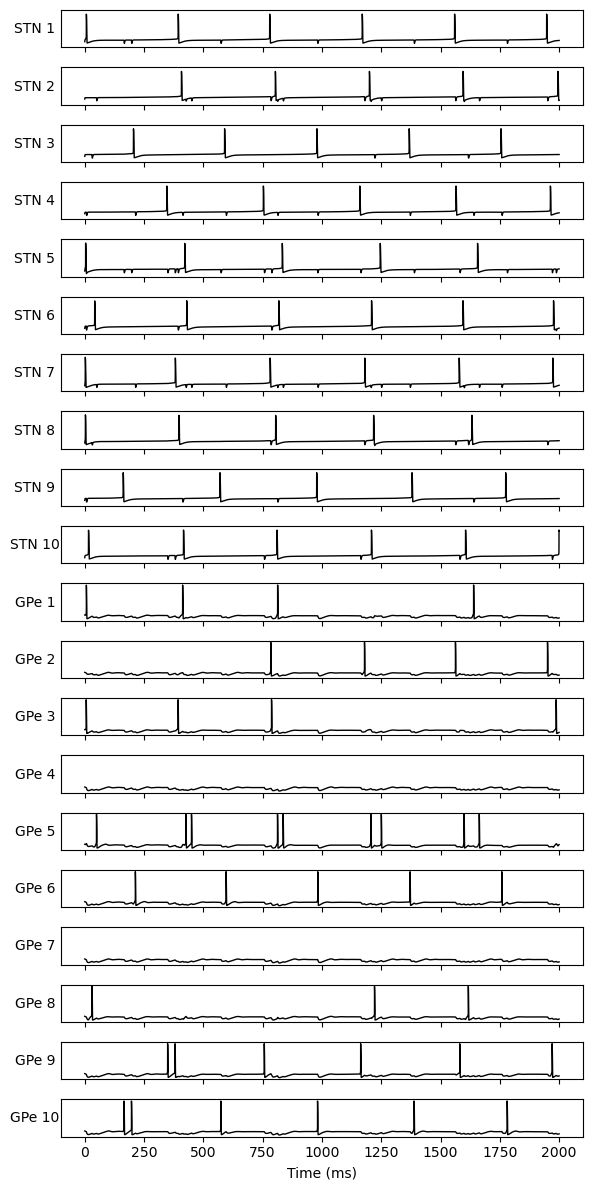

In [35]:
fig, axs = plt.subplots(N_gpe + N_stn, 1, figsize=(6, (N_gpe + N_stn)*0.6), sharex=True, sharey=True, tight_layout=True)

for i, (trace, ax) in enumerate(zip(data["v_stn"].T, axs[:N_stn])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"STN {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.05, 0.3)
    
for i, (trace, ax) in enumerate(zip(data["v_gpe"].T, axs[N_stn:])):
    ax.plot(trace, 'k', lw=1)
    ax.set_yticks([])
    ax.set_ylabel(f"GPe {i+1}", rotation=0, labelpad=10)
    ax.yaxis.set_label_coords(-0.05, 0.3)

axs[-1].xaxis.set_major_formatter(lambda x, _: f"{x*0.01:.0f}")
axs[-1].set_xlabel("Time (ms)")
    
plt.show()